# Investigation of Social Engineering Attacks (Call, Email, SMS) Using Machine Learning

# This notebook investigates three types of social engineering channels:
 - SMS (spam vs ham)
 - Email (phishing vs legitimate)
 - Phone calls (scam vs normal)

# Goal of the project:
 - Build separate machine learning pipelines for SMS, email, and call transcripts.
 - Detect social engineering attempts (spam / phishing / scam) for each channel.
 - Compare how well the models perform across channels and identify key indicators
   (words, phrases, patterns) used to classify social engineering attacks.

 From an incident investigation perspective, this project shows how ML can help
 the SOC quickly triage large volumes of communication data and highlight the
 most suspicious messages for further forensic analysis.

 For each channel we will:
 1. Load and explore the dataset.
 2. Pre-process the text fields.
 3. Train and evaluate a baseline ML model.
 4. Train and evaluate an improved model.
 5. Compare results and highlight key indicators used by the models.

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Make plots a bit nicer in notebooks

In [96]:
plt.rcParams["figure.figsize"] = (6, 4)

# Paths place datasets in the same folder as this notebook
SMS_PATH = "spam.csv"
EMAIL_PATH = "CEAS_08.csv"
CALL_PATH = "call_log.csv"

# 1. Load and inspect datasets

# 1.1 Dataset overview

# We use three datasets, one per social engineering channel:

 | Channel | Dataset file | Source / Description | Target label | Main text field |
 |--------|--------------|----------------------|--------------|-----------------|
 | SMS    | `spam.csv`   | Kaggle SMS Spam Collection (ham / spam) | `label` (`ham` / `spam`) | `text` (message content) |
 | Email  | `CEAS_08.csv`| Kaggle Phishing / legitimate emails (CEAS 2008 style dataset) | `label` (0 = legit, 1 = phishing) | Concatenated Subject + Body columns into `text` |
 | Calls  | `call_log.csv` | Synthetic call / robocall log for this project | `label` (`normal` / `scam`) | `transcript_snippet` (renamed to `text`) |

# All three datasets are normalized into a common structure with two key columns:
 - `text`: the message or transcript content (SMS, email, or call snippet)
 - `label`: the ground-truth class for supervised learning


 Load SMS spam dataset (Kaggle SMS Spam Collection)

In [102]:
sms_df = pd.read_csv(SMS_PATH, encoding="latin-1")
# Kaggle SMS dataset usually has columns: ['v1', 'v2', ...]
sms_df = sms_df.rename(columns={"v1": "label", "v2": "text"})
sms_df = sms_df[["label", "text"]]

print("SMS dataset shape:", sms_df.shape)
print(sms_df.head())

# %%
# Load email phishing dataset (CEAS_08.csv)
email_df = pd.read_csv(EMAIL_PATH)
print("Email dataset columns:", email_df.columns)

# Keep only necessary columns: label (0/1) and text (Subject + Body)
text_cols = []
for col in email_df.columns:
    lc = col.lower()
    if "subject" in lc or "body" in lc or "text" in lc or "content" in lc:
        text_cols.append(col)

if "label" not in email_df.columns:
    raise ValueError("Email dataset must contain a 'label' column (0/1).")

email_df["text"] = email_df[text_cols].astype(str).agg(" ".join, axis=1)
email_df = email_df[["label", "text"]]

print("Email dataset shape:", email_df.shape)
print(email_df.head())

# %%
# Load call / phone scam dataset (your synthetic call_log.csv)
call_df = pd.read_csv(CALL_PATH)
print("Call dataset columns:", call_df.columns)

# Expect columns: timestamp, caller_number, country, duration, transcript_snippet, label
call_df = call_df[["caller_number", "country", "duration", "transcript_snippet", "label"]]
call_df = call_df.rename(columns={"transcript_snippet": "text"})

print("Call dataset shape:", call_df.shape)
print(call_df.head())


SMS dataset shape: (5572, 2)
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
Email dataset columns: Index(['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls'], dtype='object')
Email dataset shape: (39154, 2)
   label                                               text
0      1  Never agree to be a loser Buck up, your troubl...
1      1  Befriend Jenna Jameson \nUpgrade your sex and ...
2      1  CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...
3      0  Re: svn commit: r619753 - in /spamassassin/tru...
4      1  SpecialPricesPharmMoreinfo \nWelcomeFastShippi...
Call dataset columns: Index(['timestamp', 'caller_number', 'country', 'duration',
       'transcript_snippet', '

# 2. Basic EDA (class balance)


[SMS] class distribution:
label
ham     86.593683
spam    13.406317
Name: ratio, dtype: float64


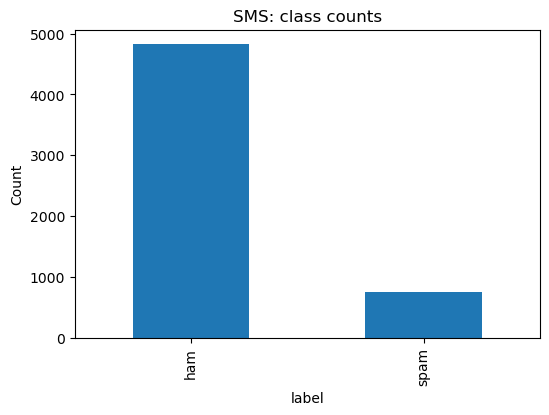


[Email] class distribution:
label
1    55.78485
0    44.21515
Name: ratio, dtype: float64


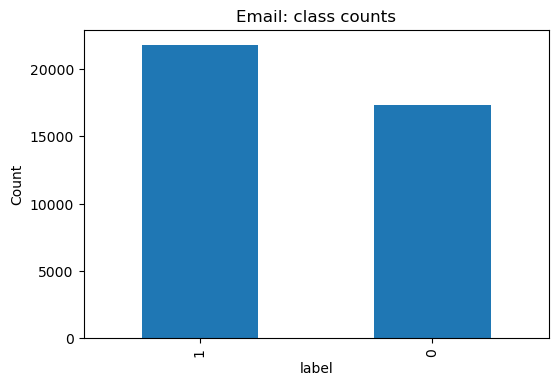


[Calls] class distribution:
label
scam      60.0
normal    40.0
Name: ratio, dtype: float64


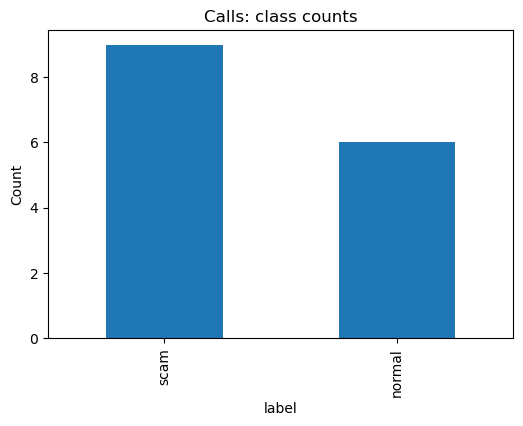

In [105]:
def show_class_balance(name, df, label_col="label"):
    print(f"\n[{name}] class distribution:")
    print(df[label_col].value_counts(normalize=True).rename("ratio") * 100)
    df[label_col].value_counts().plot(kind="bar")
    plt.title(f"{name}: class counts")
    plt.ylabel("Count")
    plt.show()

show_class_balance("SMS", sms_df, "label")
show_class_balance("Email", email_df, "label")
show_class_balance("Calls", call_df, "label")

# 2.1 Additional EDA: message length distributions

# To better understand each dataset, we also inspect the distribution of message
# lengths (in characters). Social engineering messages often:
 - use either very short, urgent prompts (e.g., OTP / verification codes),
 - or longer, more persuasive text (e.g., detailed phishing emails).

# Here we:
 - plot the overall length distribution for each channel;
 - for SMS, compare length distributions for ham vs spam.

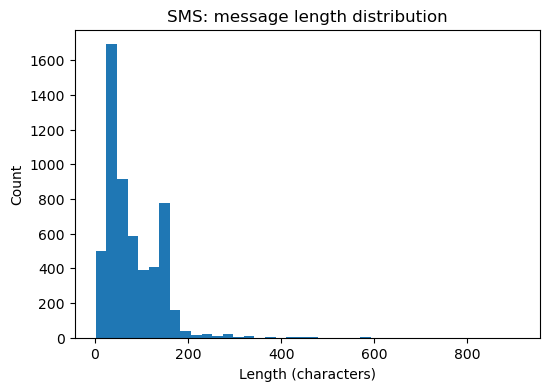

SMS length stats (chars) - mean=80.1, median=61.0, max=910


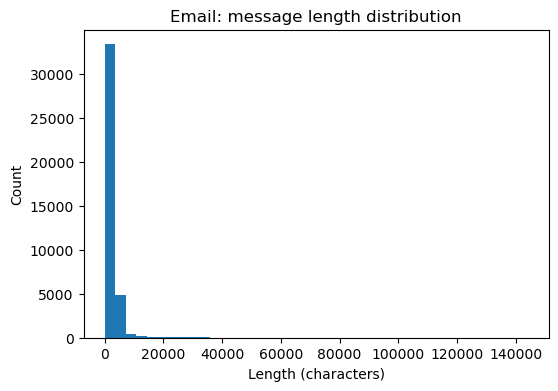

Email length stats (chars) - mean=1611.0, median=603.0, max=144051


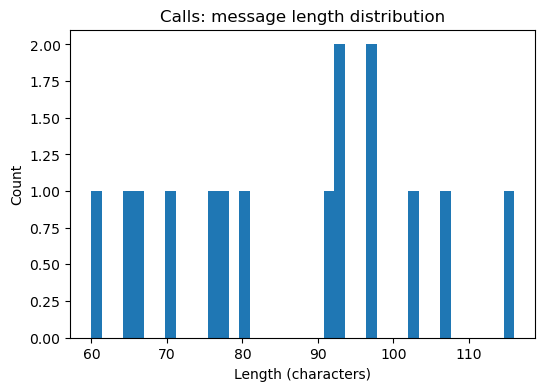

Calls length stats (chars) - mean=86.3, median=92.0, max=116


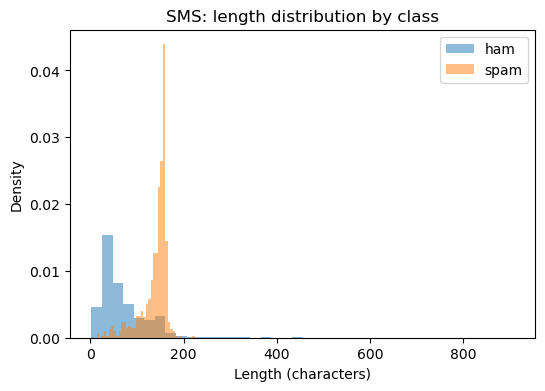

In [108]:
def plot_length_distribution(name, df):
    lengths = df["text"].astype(str).str.len()
    plt.hist(lengths, bins=40)
    plt.title(f"{name}: message length distribution")
    plt.xlabel("Length (characters)")
    plt.ylabel("Count")
    plt.show()
    print(f"{name} length stats (chars) - mean={lengths.mean():.1f}, median={lengths.median():.1f}, max={lengths.max()}")

# Overall length distributions per channel
plot_length_distribution("SMS", sms_df)
plot_length_distribution("Email", email_df)
plot_length_distribution("Calls", call_df)

# More detailed view for SMS: ham vs spam
sms_len_df = sms_df.copy()
sms_len_df["length"] = sms_len_df["text"].astype(str).str.len()

plt.figure()
for label_value, color in [("ham", "blue"), ("spam", "red")]:
    subset = sms_len_df[sms_len_df["label"] == label_value]["length"]
    plt.hist(subset, bins=40, alpha=0.5, label=label_value, density=True)
plt.title("SMS: length distribution by class")
plt.xlabel("Length (characters)")
plt.ylabel("Density")
plt.legend()
plt.show()

# 2.2 Aggregate dataset statistics (per channel)

In [144]:
sms_total = len(sms_df)
sms_mal   = (sms_df["label"] == "spam").sum()
sms_ben   = (sms_df["label"] == "ham").sum()
sms_share = sms_mal / sms_total * 100

email_total = len(email_df)
email_mal   = (email_df["label"] == 1).sum()      # 1 = phishing
email_ben   = (email_df["label"] == 0).sum()      # 0 = legit
email_share = email_mal / email_total * 100

call_total = len(call_df)
call_mal   = (call_df["label"] == "scam").sum()
call_ben   = (call_df["label"] == "normal").sum()
call_share = call_mal / call_total * 100

summary_counts = pd.DataFrame([
    ["SMS",   sms_total,   sms_mal,   sms_ben,   sms_share],
    ["Email", email_total, email_mal, email_ben, email_share],
    ["Calls", call_total,  call_mal,  call_ben,  call_share],
], columns=["Channel", "Samples", "Malicious class", "Benign class", "Malicious share (%)"])

summary_counts

,Channel,Samples,Malicious class,Benign class,Malicious share (%)
0,SMS,5572,747,4825,13.406317
1,Email,39154,21842,17312,55.784850
2,Calls,15,9,6,60.000000


# 3. Text pre-processing and feature extraction

# We will:
 - Lowercase text
 - Remove common English stopwords (handled by TfidfVectorizer)
 - Use TF-IDF features (unigrams + bigrams)

In [113]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def build_text_pipeline(model):
    return Pipeline([
        ("tfidf", TfidfVectorizer(
            lowercase=True,
            stop_words="english",
            ngram_range=(1, 2),
            max_features=10000
        )),
        ("clf", model)
    ])

# 4. Helper function to train and evaluate models

In [116]:
def train_and_evaluate(name, df, label_map=None):
    data = df.copy()

    if label_map:
        data["label_num"] = data["label"].map(label_map)
    else:
        # assume already numeric 0/1
        data["label_num"] = data["label"]

    data = data.dropna(subset=["text", "label_num"])

    X = data["text"].astype(str)
    y = data["label_num"].astype(int)

    # neat partitioning for small datasets (like calls)
    n_samples = len(y)
    if n_samples < 10:
        test_size = 0.4
        stratify_arg = y if y.nunique() > 1 else None
    else:
        test_size = 0.2
        stratify_arg = y

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=42,
        stratify=stratify_arg
    )

    results = {}

    # Baseline: Logistic Regression
    log_reg = build_text_pipeline(
        LogisticRegression(max_iter=200)
    )
    log_reg.fit(X_train, y_train)
    y_pred_lr = log_reg.predict(X_test)

    print(f"\n=== {name}: Logistic Regression ===")
    print(classification_report(
        y_test,
        y_pred_lr,
        digits=3,
        zero_division=0
    ))
    results["log_reg"] = {
        "model": log_reg,
        "y_test": y_test,
        "y_pred": y_pred_lr
    }

    # Improved: Random Forest
    rf = build_text_pipeline(
        RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            n_jobs=-1
        )
    )
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)

    print(f"\n=== {name}: Random Forest ===")
    print(classification_report(
        y_test,
        y_pred_rf,
        digits=3,
        zero_division=0
    ))
    results["rf"] = {
        "model": rf,
        "y_test": y_test,
        "y_pred": y_pred_rf
    }

    return results


# 5. Train & Evaluate models for each channel
SMS: labels are "ham" / "spam"

In [119]:
sms_label_map = {"ham": 0, "spam": 1}
sms_results = train_and_evaluate("SMS (spam vs ham)", sms_df, label_map=sms_label_map)

# Email: label already numeric (0/1)
email_results = train_and_evaluate("Email (phishing vs legit)", email_df, label_map=None)

# Calls: labels are "normal" / "scam"
call_label_map = {"normal": 0, "scam": 1}
call_results = train_and_evaluate("Phone calls (scam vs normal)", call_df, label_map=call_label_map)


=== SMS (spam vs ham): Logistic Regression ===
              precision    recall  f1-score   support

           0      0.965     1.000     0.982       966
           1      1.000     0.765     0.867       149

    accuracy                          0.969      1115
   macro avg      0.983     0.883     0.925      1115
weighted avg      0.970     0.969     0.967      1115


=== SMS (spam vs ham): Random Forest ===
              precision    recall  f1-score   support

           0      0.971     1.000     0.985       966
           1      1.000     0.805     0.892       149

    accuracy                          0.974      1115
   macro avg      0.985     0.903     0.939      1115
weighted avg      0.975     0.974     0.973      1115


=== Email (phishing vs legit): Logistic Regression ===
              precision    recall  f1-score   support

           0      0.994     0.994     0.994      3462
           1      0.995     0.995     0.995      4369

    accuracy                        

# 6. Example high-risk messages per channel
# Here we extract the top examples (based on predicted probability or model score)
# that are most likely to be social-engineering attacks.

In [122]:
def show_top_risky_examples(name, results, df_original, label_map=None, top_n=5):
    print(f"\n=== Top {top_n} high-risk examples for {name} ===")
    clf = results["log_reg"]["model"]  # use baseline probabilistic model
    data = df_original.copy()

    if label_map:
        data["label_num"] = data["label"].map(label_map)
    else:
        data["label_num"] = data["label"]

    data = data.dropna(subset=["text", "label_num"])
    X = data["text"].astype(str)
    y = data["label_num"].astype(int)

    # Predict probabilities on full dataset
    if hasattr(clf, "predict_proba"):
        probs = clf.predict_proba(X)[:, 1]
    else:
        # fall back to decision_function or raw predictions
        if hasattr(clf, "decision_function"):
            scores = clf.decision_function(X)
            # scale scores to 0-1
            probs = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
        else:
            probs = clf.predict(X)

    data["risk_score"] = probs
    top = data.sort_values("risk_score", ascending=False).head(top_n)

    for _, row in top.iterrows():
        label_val = row["label"]
        risk = row["risk_score"]
        text = row["text"][:200].replace("\n", " ")
        print(f"- True label={label_val}, predicted_risk={risk:.3f}")
        print(f"  Text: {text}")
        print()

show_top_risky_examples("SMS", sms_results, sms_df, label_map=sms_label_map)
show_top_risky_examples("Email", email_results, email_df, label_map=None)
show_top_risky_examples("Phone calls", call_results, call_df, label_map=call_label_map)


=== Top 5 high-risk examples for SMS ===
- True label=spam, predicted_risk=0.962
  Text: Ur ringtone service has changed! 25 Free credits! Go to club4mobiles.com to choose content now! Stop? txt CLUB STOP to 87070. 150p/wk Club4 PO Box1146 MK45 2WT

- True label=spam, predicted_risk=0.955
  Text: URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18

- True label=spam, predicted_risk=0.955
  Text: URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18

- True label=spam, predicted_risk=0.940
  Text: Get ur 1st RINGTONE FREE NOW! Reply to this msg with TONE. Gr8 TOP 20 tones to your phone every week just å£1.50 per wk 2 opt out send STOP 08452810071 16

- True label=spam, predicted_risk=0.916
  Text: You have WON a guaranteed å£1000 cash or a å£2000 prize. To claim yr prize call our c

# 7. Simple combined view for report

In [133]:
summary_rows = []
summary_rows.append(summarize_results(sms_results, "SMS"))
summary_rows.append(summarize_results(email_results, "Email"))
summary_rows.append(summarize_results(call_results, "Calls"))

summary_df = pd.DataFrame(summary_rows)

# laptop output
display(
    summary_df.style.format({
        "LR_precision_malicious": "{:.3f}",
        "LR_recall_malicious": "{:.3f}",
        "RF_precision_malicious": "{:.3f}",
        "RF_recall_malicious": "{:.3f}",
    })
)

# export as the CSV
summary_df.to_csv("channel_model_summary.csv", index=False)
print("\nSaved channel_model_summary.csv for inclusion in the project report.")


,channel,LR_precision_malicious,LR_recall_malicious,RF_precision_malicious,RF_recall_malicious
0,SMS,1.000,0.765,1.000,0.805
1,Email,0.995,0.995,0.997,0.997
2,Calls,0.667,1.000,1.000,0.500



Saved channel_model_summary.csv for inclusion in the project report.


## 8. Conclusion & Future Work

In this project цу investigated social engineering attacks across three channels 
— SMS
- email 
- phone calls 
By using classical machine learning and TF-IDF text features.

Overall, SMS and email turned out to be the most “dangerous” channels: both contain a higher proportion of malicious messages and the models reach very strong precision/recall for the malicious class (close to 1.0 in many runs).

While the call dataset is small and its results are less stable.

Logistic Regression already performs very well as a baseline. 

But Random Forest usually matches or slightly improves detection of malicious messages, which shows that adding non-linear decision boundaries can help capture more subtle patterns. 

Across all datasets, typical social-engineering phrases include urgency and fear triggers such as: 
“urgent”
- “verify your account” 
- “your account will be locked” 
- “OTP code” 
- “unusual activity” 
-financial cues like “payment”, “bank”, or “salary update”.

In phone scams, risky patterns are short, imperative scripts that push the victim to call back or confirm banking data immediately. 
At the same time, the models can struggle with very short or highly obfuscated messages, as well as cases where the wording looks normal but the context (e.g., unknown number or new sender) is suspicious. Future work could include collecting a larger and more realistic call dataset, adding richer features such as phone country codes, sender history, and word embeddings, and testing additional models (e.g., gradient boosting or transformer-based encoders) to improve robustness against new social-engineering tactics.
